In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pickle as pkl

In [2]:
id_list = ["id-564418", "id-563846", "id-563643", "id-565822", "id-555224", "id-559855"]

In [3]:
CTR_data = []
for id in id_list:
    new_data = pkl.load(open(id+".pkl",'rb'))
    CTR_data.append(new_data)
CTR_data = np.asarray(CTR_data)

In [4]:
CTR_data

array([[0.01454923, 0.01454923, 0.01454923, ..., 0.01366768, 0.01366768,
        0.01366768],
       [0.04838016, 0.04838016, 0.04838016, ..., 0.03480668, 0.03480668,
        0.03480668],
       [0.04996583, 0.04996583, 0.04996583, ..., 0.03996111, 0.03996111,
        0.03996111],
       [0.05075375, 0.05075375, 0.05075375, ..., 0.04311419, 0.04311419,
        0.04311419],
       [0.03648495, 0.03648495, 0.03648495, ..., 0.02511878, 0.02511878,
        0.02511878],
       [0.02399832, 0.02399832, 0.02399832, ..., 0.02204665, 0.02204665,
        0.02204665]])

In [23]:
CTR_data[:,::100000]

array([[0.01454923, 0.01459739, 0.01464529, ..., 0.01366932, 0.01366885,
        0.01366831],
       [0.04838016, 0.04835972, 0.04833925, ..., 0.03467951, 0.03472182,
        0.03476428],
       [0.04996583, 0.04993902, 0.0499121 , ..., 0.03979972, 0.03985369,
        0.03990753],
       [0.05075375, 0.05079163, 0.05083008, ..., 0.04318221, 0.04315959,
        0.0431369 ],
       [0.03648495, 0.03648703, 0.03648897, ..., 0.0252184 , 0.02518516,
        0.02515199],
       [0.02399832, 0.02396186, 0.02392539, ..., 0.02202   , 0.02202887,
        0.02203775]])

Text(0.5, 1.0, 'Click-through rates (CTR) of two contents (arms)')

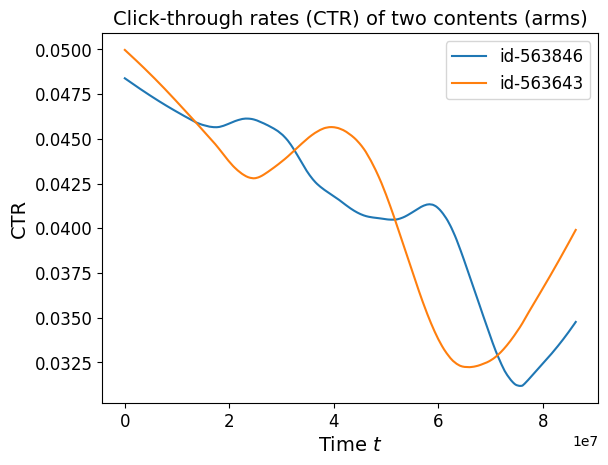

In [16]:
plt.plot(100000*np.arange(864), CTR_data[1,::100000], label='id-563846')
plt.plot(100000*np.arange(864), CTR_data[2,::100000], label='id-563643')
plt.legend(fontsize=12)
plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('CTR', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Click-through rates (CTR) of two contents (arms)", fontsize=14)

Text(0.5, 1.0, 'Mean reward functions of six arms')

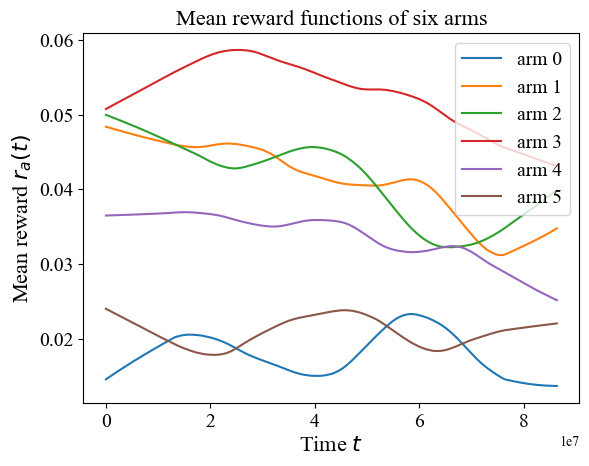

In [9]:
# Use Times New Roman font for LaTeX rendering
from matplotlib import rc
rc('font', family='Times New Roman')

plt.plot(100000*np.arange(864), CTR_data[0,::100000], label='arm 0')
plt.plot(100000*np.arange(864), CTR_data[1,::100000], label='arm 1')
plt.plot(100000*np.arange(864), CTR_data[2,::100000], label='arm 2')
plt.plot(100000*np.arange(864), CTR_data[3,::100000], label='arm 3')
plt.plot(100000*np.arange(864), CTR_data[4,::100000], label='arm 4')
plt.plot(100000*np.arange(864), CTR_data[5,::100000], label='arm 5')
plt.legend(fontsize=14)
plt.xlabel('Time $t$', fontsize=16)
plt.ylabel('Mean reward $r_a(t)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Mean reward functions of six arms", fontsize=16)

In [18]:
def Protocol(num_arms, gamma, batch_size, rates):
    '''     
    Interaction between the algorithm and the enviornment
    input: time horizon T, algorithm budget, algorithm epoch size, reward rates
    output: optimal reward, algorithm reward, regret
    '''

    opt_reward = OPT(rates)
  
    alg_reward = Rexp3(num_arms, gamma, batch_size, rates)
    
    regret = opt_reward - alg_reward
    
    return opt_reward, alg_reward, regret

In [19]:
def OPT(rates):
    '''
    Get the optimal reward of an instance of rates
    '''

    opt_reward = np.sum(np.max(rates,axis=0))  # recall that the optimal policy receives reward max(E[tape1[t]], E[tape2[t]]) at time t
    
    return opt_reward

In [26]:
def Rexp3(num_arms, gamma, batch_size, rates):
    alg_reward = 0
    batch_index = 0
    horizon = len(rates[0])
    rand_values = np.random.rand(horizon)
    
    while batch_index <= (horizon//batch_size):
        tau = batch_index * batch_size
        weights = np.ones(num_arms)
        for t in range(tau, min(tau+batch_size, horizon)):
            # Probability distribution for drawing arms
            dist = (1 - gamma) * weights / np.sum(weights) + gamma / num_arms
            
            # Draw an arm randomly with probability proportional to the weight of the arm
#             chosen_arm = np.random.choice(num_arms, p=distribution)
            cum_dist = np.cumsum(dist)
            chosen_arm = np.searchsorted(cum_dist,rand_values[t])
            
            # Receive a reward
            reward = rates[chosen_arm][t]
            alg_reward = alg_reward + reward
            
            # Update the weight for the chosen arm
            prob = dist[chosen_arm]
            weights[chosen_arm] = weights[chosen_arm] * np.exp(gamma * (reward / prob) / num_arms)
        batch_index = batch_index+1
    return alg_reward

In [28]:
def Regrets(num_arms, variation_budget, data):
    T = len(data[0])  # start with time horizon equal to the length of the dataset
    V = variation_budget  # total variation budget
    K = num_arms  # number of arms
    l = math.floor(np.log2(T))  # log of time horizon
    
    regrets = np.zeros(l+1)
    opt_rewards = np.zeros(l+1)
    alg_rewards = np.zeros(l+1)

    rates = np.copy(data)

    while T>30000:
        i = math.floor(np.log2(T))  # log of time horizon
        print("log horizon:", math.floor(np.log2(T)))
        Delta = math.ceil((K*math.log(K))**(1/3)*(T/V)**(2/3))  # batch size
        gamma = min(1, math.sqrt(K*math.log(K)/((math.e-1)*Delta)))  # exploration probability
        start = time.time()
        opt_rewards[i], alg_rewards[i], regrets[i] = Protocol(num_arms=num_arms, gamma=gamma, batch_size=Delta, rates=rates)
        end = time.time()
        print("time:", end-start)
        print('regret:', regrets[i])

        T = int(T/2)  # consider time horizon T/2 next
        rates = rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
        i = i+1

    return regrets, opt_rewards

In [107]:
program_start = time.time()

regrets, opt_rewards = Regrets(num_arms=2, variation_budget=0.05, data=CTR_data[1:3])

program_end = time.time()
print("program time:", program_end-program_start)

log horizon: 26
time: 440.01731419563293
regret: 66297.60759431683
log horizon: 25
time: 223.0568928718567
regret: 37524.12416269304
log horizon: 24
time: 109.38368487358093
regret: 20677.2090655918
log horizon: 23
time: 55.211190938949585
regret: 11189.972844079544
log horizon: 22
time: 28.200990915298462
regret: 6008.342987106269
log horizon: 21
time: 14.414137125015259
regret: 3156.6605279901123
log horizon: 20
time: 7.6455078125
regret: 1664.6040249220387
log horizon: 19
time: 3.8068530559539795
regret: 863.2403020509628
log horizon: 18
time: 2.100930690765381
regret: 442.45591557693297
log horizon: 17
time: 1.1727721691131592
regret: 227.41387798820142
log horizon: 16
time: 0.44442296028137207
regret: 116.8007322883991
log horizon: 15
time: 0.22254490852355957
regret: 59.4901549120998
program time: 886.5938539505005


Text(0.5, 1.0, 'Regret as a function of the horizon length $T$')

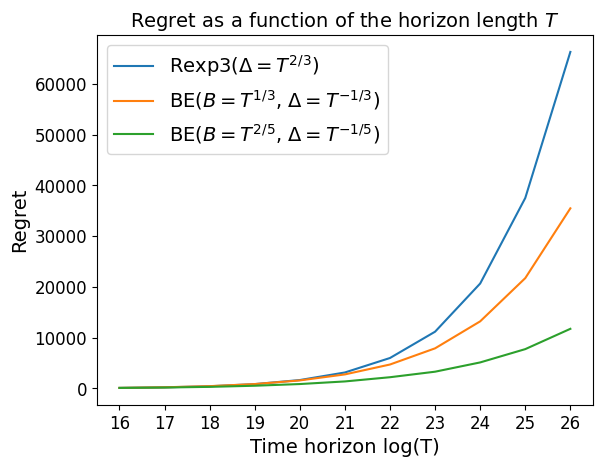

In [141]:
# id-563846 vs id-563643
plt.plot(np.arange(16,27), regrets[16:], label="Rexp3($\Delta=T^{2/3}$)")
plt.plot(np.arange(16,27), np.flip(regrets1), label="BE($B=T^{1/3}$, $\Delta=T^{-1/3}$)")
plt.plot(np.arange(16,27), np.flip(regrets2), label="BE($B=T^{2/5}$, $\Delta=T^{-1/5}$)")
plt.legend(fontsize=14)
plt.xlabel('Time horizon log(T)', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.xticks(range(16,27), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Regret as a function of the horizon length $T$", fontsize=14)

Text(0.5, 1.0, 'Regret as a function of the horizon length $T$ (log-log plot)')

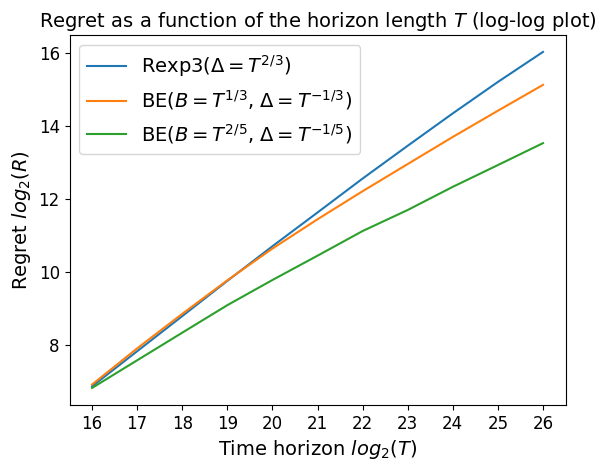

In [151]:
# id-563846 vs id-563643
plt.plot(np.arange(16,27), np.log2(regrets[16:]), label="Rexp3($\Delta=T^{2/3}$)")
plt.plot(np.arange(16,27), np.log2(np.flip(regrets1)), label="BE($B=T^{1/3}$, $\Delta=T^{-1/3}$)")
plt.plot(np.arange(16,27), np.log2(np.flip(regrets2)), label="BE($B=T^{2/5}$, $\Delta=T^{-1/5}$)")
plt.legend(fontsize=14)
plt.xlabel('Time horizon $log_2(T)$', fontsize=14)
plt.ylabel('Regret $log_2(R)$', fontsize=14)
plt.xticks(range(16,27), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Regret as a function of the horizon length $T$ (log-log plot)", fontsize=14)

In [113]:
regrets1 = np.array([35489.17503546, 21739.98626761, 13226.48472927,  7911.38269841,
         4725.67950181,  2775.86363762,  1592.50624661,   872.3929744 ,
          461.91300057,   240.04096844,   120.92312979])

In [114]:
regrets2 = np.array([11754.54794245,  7756.71915681,  5136.23913346,  3309.82420722,
         2220.91051042,  1391.57238716,   877.60294282,   544.57286458,
          323.17392609,   191.45187535,   113.37625716])

In [29]:
program_start = time.time()

regrets, opt_rewards = Regrets(num_arms=6, variation_budget=0.05, data=CTR_data)

program_end = time.time()
print("program time:", program_end-program_start)

log horizon: 26
time: 764.8132929801941
regret: 211839.75829371065
log horizon: 25
time: 430.3751480579376
regret: 132567.90800835658
log horizon: 24
time: 1379.489827156067
regret: 82567.30518480879
log horizon: 23
time: 128.1155161857605
regret: 51362.70642150391
log horizon: 22
time: 61.3156361579895
regret: 31370.12529803405
log horizon: 21
time: 32.514728307724
regret: 19185.599995762546
log horizon: 20
time: 24.785533905029297
regret: 11237.985388051799
log horizon: 19
time: 9.323126077651978
regret: 6681.674527917647
log horizon: 18
time: 6.692873954772949
regret: 3729.4135708935355
log horizon: 17
time: 3.8922500610351562
regret: 2094.892834339641
log horizon: 16
time: 3.343045234680176
regret: 1133.7536146704483
log horizon: 15
time: 1.7838408946990967
regret: 605.7982338191464
program time: 2861.7812077999115


Text(0.5, 1.0, 'Regret as a function of the horizon length $T$')

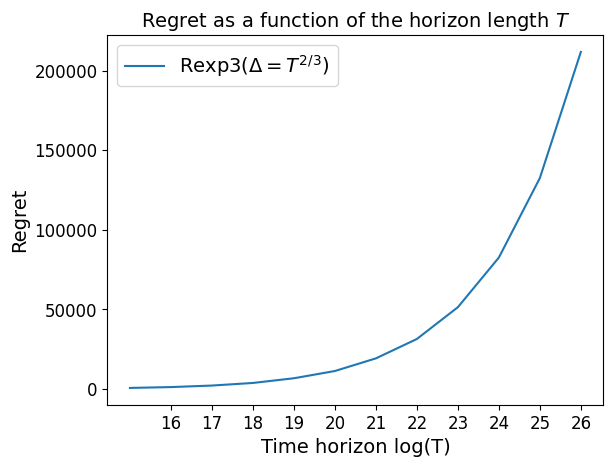

In [31]:
# K=6 arms
plt.plot(np.arange(15,27), regrets[15:], label="Rexp3($\Delta=T^{2/3}$)")
plt.legend(fontsize=14)
plt.xlabel('Time horizon log(T)', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.xticks(range(16,27), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Regret as a function of the horizon length $T$", fontsize=14)

Text(0.5, 1.0, 'Regret as a function of the horizon length $T$ (log-log plot)')

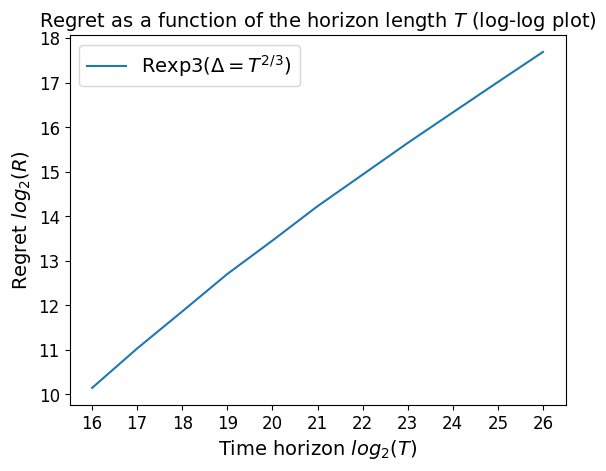

In [32]:
plt.plot(np.arange(16,27), np.log2(regrets[16:]), label="Rexp3($\Delta=T^{2/3}$)")
plt.legend(fontsize=14)
plt.xlabel('Time horizon $log_2(T)$', fontsize=14)
plt.ylabel('Regret $log_2(R)$', fontsize=14)
plt.xticks(range(16,27), fontsize=12)
plt.yticks(fontsize=12)
plt.title("Regret as a function of the horizon length $T$ (log-log plot)", fontsize=14)

In [34]:
regrets[15:]

array([   605.79823382,   1133.75361467,   2094.89283434,   3729.41357089,
         6681.67452792,  11237.98538805,  19185.59999576,  31370.12529803,
        51362.7064215 ,  82567.30518481, 132567.90800836, 211839.75829371])